In [1]:
import os
os.chdir('..')

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [3]:
RESULTS_DIR = "results/movielens_evaluation_v10"

In [4]:
p = Path(RESULTS_DIR)

In [5]:
pickle_paths = p.glob("./*.pickle")

In [6]:
pickle_paths

<generator object Path.glob at 0x10c524270>

In [7]:
reward_dict = {}
ndcg_dict = {}
time_dict = {}
for i, p in enumerate(pickle_paths):
    with open(p, "rb") as f:
        d = pickle.load(f)
    stats_dict = d[0][0]
    one_rew_dict = d[1]
    one_ndcg_dict = d[2]
    for key in one_rew_dict:
        rew_list = one_rew_dict[key]
        ndcg_list = one_ndcg_dict[key]
        mean_rew = np.mean(np.stack(rew_list), axis=0)
        mean_ndcg = np.mean(np.stack(ndcg_list), axis=0)
        reward_dict[key] = mean_rew
        ndcg_dict[key] = mean_ndcg
        assert key == stats_dict[0]
        time_dict[key] = stats_dict[1]['Time mean']

In [8]:
list(reward_dict.keys())

['BCMAB-RP (d=120, gamma=0.99, a=0.1)',
 'CBRAP (d=12, alpha=0.6)',
 'E-Greedy (epsilon=0.001)',
 'DeepFM',
 'BCMAB-RP (d=24, gamma=0.99, a=0.1)',
 'CBRAP (d=60, alpha=0.6)',
 'LinearTS (nu=0.3)',
 'CBRAP (d=120, alpha=0.6)',
 'BCMAB-RP (d=6, gamma=0.99, a=0.1)',
 'LinUCB (alpha=0.7)',
 'CBRAP (d=24, alpha=0.6)',
 'BCMAB-RP (d=12, gamma=0.99, a=0.1)',
 'RandomPolicy',
 'DLinTS (gamma=0.99, a=0.1)',
 'CBRAP (d=6, alpha=0.6)',
 'BCMAB-RP (d=60, gamma=0.99, a=0.1)']

In [9]:
new_reward_dict = {
    'BCMAB-RP (d=120)': reward_dict['BCMAB-RP (d=120, gamma=0.99, a=0.1)'],
    'CBRAP (d=12)': reward_dict['CBRAP (d=12, alpha=0.6)'],
    r'$\epsilon$-Greedy':  reward_dict['E-Greedy (epsilon=0.001)'],
    'DeepFM': reward_dict['DeepFM'],
    'BCMAB-RP (d=24)': reward_dict['BCMAB-RP (d=24, gamma=0.99, a=0.1)'],
    'CBRAP (d=60)': reward_dict['CBRAP (d=60, alpha=0.6)'],
    'LinTS': reward_dict['LinearTS (nu=0.3)'],
    'CBRAP (d=120)': reward_dict['CBRAP (d=120, alpha=0.6)'],
    'BCMAB-RP (d=6)': reward_dict['BCMAB-RP (d=6, gamma=0.99, a=0.1)'],
    'LinUCB': reward_dict['LinUCB (alpha=0.7)'],
    'CBRAP (d=24)': reward_dict['CBRAP (d=24, alpha=0.6)'],
    'BCMAB-RP (d=12)': reward_dict['BCMAB-RP (d=12, gamma=0.99, a=0.1)'],
    'Random': reward_dict['RandomPolicy'],
    'D-LinTS': reward_dict['DLinTS (gamma=0.99, a=0.1)'],
    'CBRAP (d=6)': reward_dict['CBRAP (d=6, alpha=0.6)'],
    'BCMAB-RP (d=60)': reward_dict['BCMAB-RP (d=60, gamma=0.99, a=0.1)'],
}

In [10]:
reward_dict = new_reward_dict

In [11]:
CHANGE_POINTS = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 90000, 100000]

## Plot the results

In [12]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    
    N = 10
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on MovieLens')

    plt.legend(bbox_to_anchor=(1.00, 1.0));
    plt.savefig(f'movielens_results_ndcg', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

In [13]:
def plot_ctrs_or_rewards(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    N = 10
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
        else:
            to_plot = rewards
        max_vline=max(max_vline, max(to_plot[N:]))
            
        ax.plot(to_plot[N:], label=label)
        
    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.45
    )    
     
    extraticks = change_points
    plt.xticks(extraticks, rotation=20)
#     plt.yticks(fontsize=25)
    
    ax.set_xlabel('Trial')
    ax.set_ylabel(f'{plot_type}')

    plt.legend(bbox_to_anchor=(1.00, 1.0));
    
    plot_name = 'ctr' if plot_type == "CTR" else 'reward'
    plt.savefig(f'plotting/movielens_results_{plot_name}', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

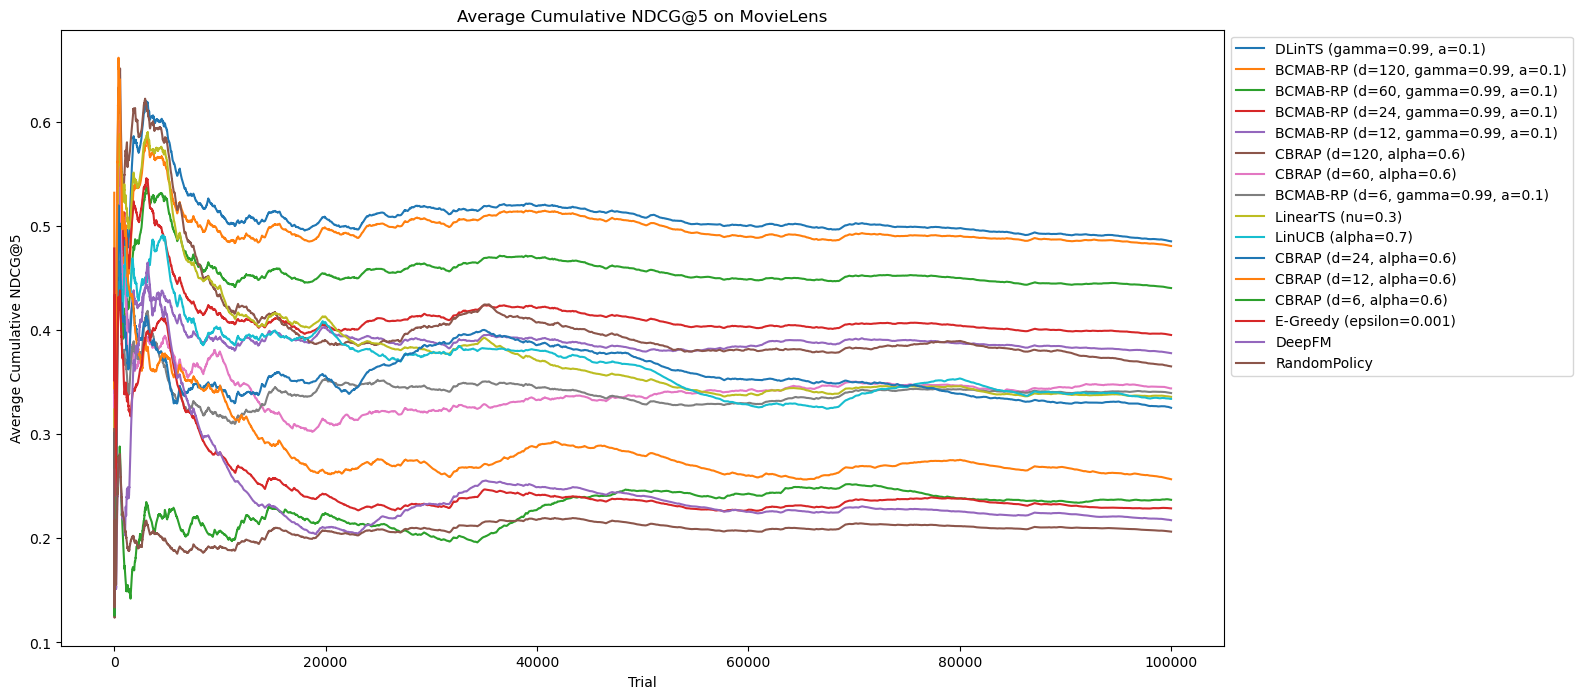

In [14]:
plot_ndcg(ndcg_dict)

In [21]:
def plot_ctrs_or_rewards(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    N = 10
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('o', 'tab:blue'),
        1: ('v','tab:orange'),
        2: ('^','tab:green'),
        3: ('<','tab:red'),
        4: ('8','tab:purple'),
        5: ('>', 'tab:brown'),
        6: ('s', 'tab:pink'),
        7: ('p', 'tab:grey'),
        8: ('*', 'tab:olive'),
        9: ('h', 'tab:blue'),
        10: ('P','tab:orange'),
        11: ('x','tab:green'),
        12: ('d','tab:red'),
        13: ('<','tab:purple'),
        14: ('X', 'tab:brown'),
        15: ('v', 'xkcd:azure'),
    }
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        mark, color = ind_to_params[ind]
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
        else:
            to_plot = rewards
        max_vline=max(max_vline, max(to_plot[N:]))
            
        ax.plot(
            to_plot[N:], label=label,
                marker=mark, markevery=7000, markersize=9, markeredgewidth=1.7,
                fillstyle='none', color=color,
                linewidth=2.1,
        )
        
    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.45
    )    
     
    extraticks = change_points
    plt.xticks(extraticks, rotation=30, fontsize=23)
    plt.yticks(fontsize=23)
    
    ax.set_xlabel('Time Step', fontsize=36)
    ylabel = 'Click-Through Rate' if plot_type =='CTR' else 'Cumulative Reward'
    ax.set_ylabel(f'{ylabel}', fontsize=36)
    ax.set_xlim(-500, 100500)

    plt.legend(prop={'size': 18}, ncol=4, bbox_to_anchor=(-0.055, 1.278), loc='upper left',
                       );

    plot_name = 'ctr' if plot_type == "CTR" else 'reward'
    plt.savefig(f'plotting/movielens_results_{plot_name}', dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight');
    plt.show();

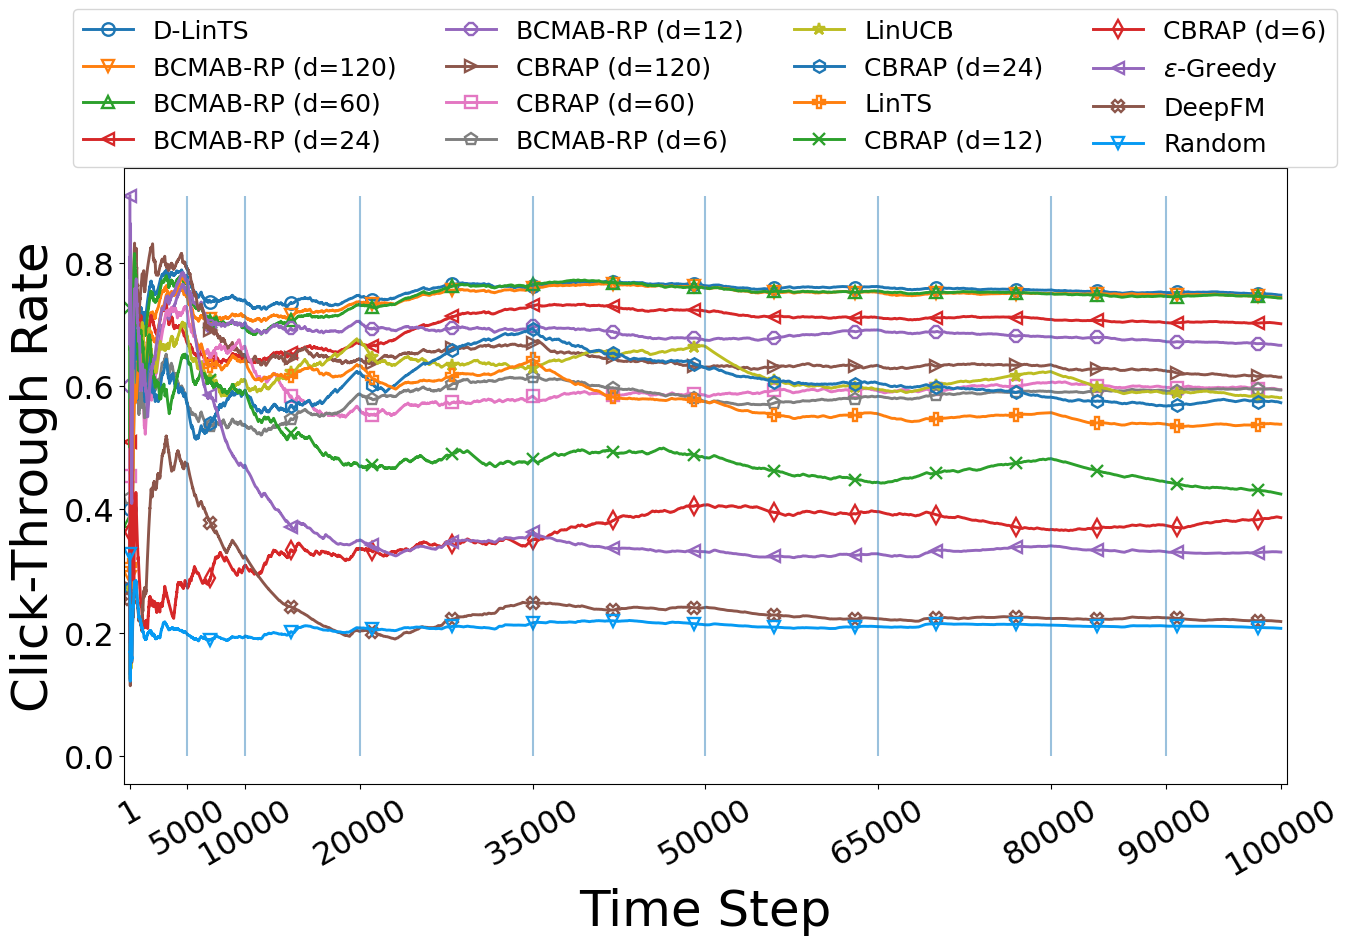

In [22]:
plot_ctrs_or_rewards(reward_dict, "CTR", CHANGE_POINTS);

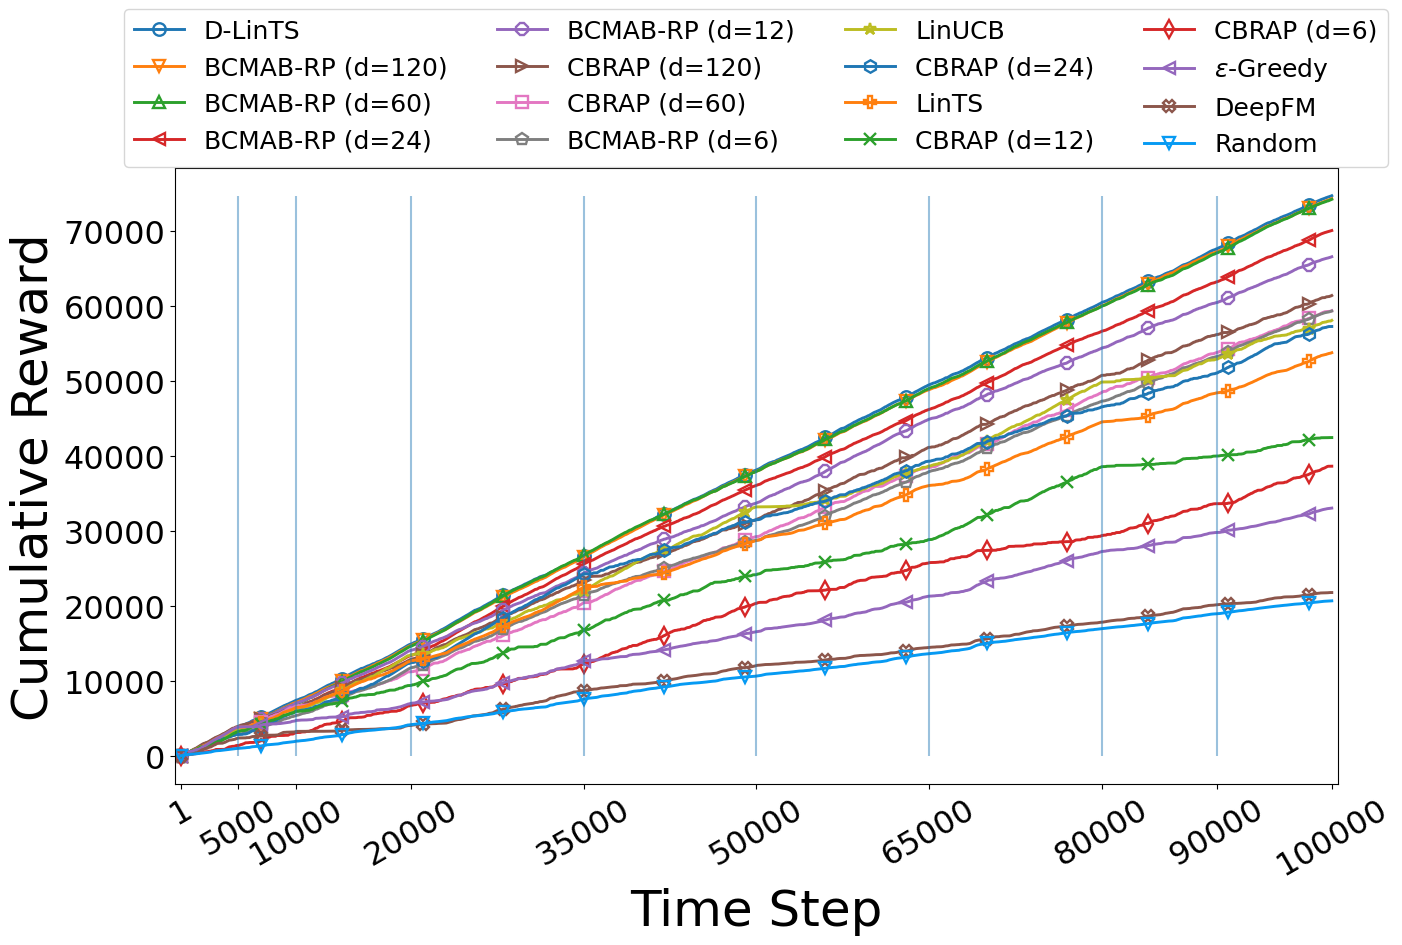

In [23]:
plot_ctrs_or_rewards(reward_dict, "Cumulative reward", CHANGE_POINTS);

In [18]:
print('Time')
{k: round(v,1) for k, v in time_dict.items()}

Time


{'BCMAB-RP (d=120, gamma=0.99, a=0.1)': 1753.4,
 'CBRAP (d=12, alpha=0.6)': 1645.8,
 'E-Greedy (epsilon=0.001)': 686.7,
 'DeepFM': 3791.9,
 'BCMAB-RP (d=24, gamma=0.99, a=0.1)': 1109.2,
 'CBRAP (d=60, alpha=0.6)': 1989.3,
 'LinearTS (nu=0.3)': 1370.9,
 'CBRAP (d=120, alpha=0.6)': 2440.3,
 'BCMAB-RP (d=6, gamma=0.99, a=0.1)': 1027.4,
 'LinUCB (alpha=0.7)': 2452.2,
 'CBRAP (d=24, alpha=0.6)': 1917.0,
 'BCMAB-RP (d=12, gamma=0.99, a=0.1)': 1054.9,
 'RandomPolicy': 857.8,
 'DLinTS (gamma=0.99, a=0.1)': 1739.8,
 'CBRAP (d=6, alpha=0.6)': 1647.7,
 'BCMAB-RP (d=60, gamma=0.99, a=0.1)': 1231.5}

In [19]:
print('Reward')
[(k,v[-1][0]) for k,v in reward_dict.items()]

Reward


[('BCMAB-RP (d=120)', 74379.8),
 ('CBRAP (d=12)', 42485.0),
 ('$\\epsilon$-Greedy', 33066.4),
 ('DeepFM', 21792.2),
 ('BCMAB-RP (d=24)', 70130.0),
 ('CBRAP (d=60)', 59425.0),
 ('LinTS', 53814.0),
 ('CBRAP (d=120)', 61445.0),
 ('BCMAB-RP (d=6)', 59379.8),
 ('LinUCB', 58130.0),
 ('CBRAP (d=24)', 57314.0),
 ('BCMAB-RP (d=12)', 66628.6),
 ('Random', 20683.4),
 ('D-LinTS', 74771.6),
 ('CBRAP (d=6)', 38660.0),
 ('BCMAB-RP (d=60)', 74294.6)]

In [20]:
print('NDCG')
[(k, round(v[-1][0],1)) for k,v in ndcg_dict.items()]

NDCG


[('BCMAB-RP (d=120, gamma=0.99, a=0.1)', 48048.1),
 ('CBRAP (d=12, alpha=0.6)', 25662.7),
 ('E-Greedy (epsilon=0.001)', 22866.9),
 ('DeepFM', 21731.2),
 ('BCMAB-RP (d=24, gamma=0.99, a=0.1)', 39509.2),
 ('CBRAP (d=60, alpha=0.6)', 34382.5),
 ('LinearTS (nu=0.3)', 33572.3),
 ('CBRAP (d=120, alpha=0.6)', 36496.0),
 ('BCMAB-RP (d=6, gamma=0.99, a=0.1)', 33934.6),
 ('LinUCB (alpha=0.7)', 33378.2),
 ('CBRAP (d=24, alpha=0.6)', 32521.0),
 ('BCMAB-RP (d=12, gamma=0.99, a=0.1)', 37764.2),
 ('RandomPolicy', 20634.6),
 ('DLinTS (gamma=0.99, a=0.1)', 48499.1),
 ('CBRAP (d=6, alpha=0.6)', 23687.6),
 ('BCMAB-RP (d=60, gamma=0.99, a=0.1)', 44014.6)]